# Setup
Comment out javascript if jupyter widgets not installed

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
from pathlib import Path
from dataset import Video

# Create dataset
Creating data for input to the model is a little tricky. Details in the readme.

In [10]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/train') #in jpg format, from included script
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/labels.json') # in json format, from included script

In [11]:
from dataset_import import get_training_set, get_validation_set, get_test_set
from model import generate_model
class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    
input_args=Args()

In [12]:
from spatial_transforms2 import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms2 import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose

In [13]:
norm_value=255 #for rgb data

scale_step=0.84089 #for the kinetics dataset
scales = [1]
n_scales=5
for i in range(1, n_scales):
    scales.append(scales[-1] * scale_step)
    
sample_size=112 # default for kinetics
sample_duration=4 # my choosen window size
norm_method = Normalize([110.636/norm_value, 103.1606/norm_value, 96.29/norm_value], 
                        [38.756/norm_value, 37.8824/norm_value, 40.03/norm_value]) #per the averages of the dataset
crop_method = MultiScaleRandomCrop(scales, sample_size)
spatial_transform = Compose([
            crop_method,
            RandomHorizontalFlip(),
            ToTensor(norm_value), norm_method])

In [14]:
temporal_transform = TemporalRandomCrop(sample_duration)
target_transform = ClassLabel()

In [15]:
training_data = get_training_set(input_args, spatial_transform,
                                 temporal_transform, target_transform)

dataset loading [0/191]


In [16]:
batch_size=16 #32 was too large!
n_threads=4
train_loader = torch.utils.data.DataLoader(
            training_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=n_threads,
            pin_memory=True)

# Validation Set
I have one video for training, another for test, and another for validation. Using the ActivityNet data crawler, these videos are easily transformed into the appropriate format as described in the readme.

In [17]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/val')
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/labels.json')

class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    n_val_samples=5
    sample_duration=4
    
val_args=Args()

In [18]:
validation_data = get_validation_set(
    val_args, spatial_transform, temporal_transform, target_transform)

dataset loading [0/56]


In [19]:
val_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

# Load Pre-Trained Model
### First, import kinetics pretrained model exactly as is

In [20]:
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
import torch.nn as nn

model = resnext.resnet101(
    sample_size=112, #height and width of inputs
    sample_duration=4, #temporal, 16!!!
    num_classes=400) 

In [21]:
#from opts import parse_opts
from model import generate_model
class Args:
    sample_size = 112
    sample_duration = 4 #16!!!
    n_classes = 400
    mode='feature'
    model_name='resnext'
    model_depth=101
    resnet_shortcut='B'
    resnext_cardinality=32
    no_cuda=False
    batch_size=16
    n_threads=4

opt=Args()
model=generate_model(opt)

pretrain_path=Path('/media/tris/tris_files/github/csce_courses/video-classification-3d-cnn-pytorch/resnext-101-kinetics.pth')
model_data = torch.load(pretrain_path)
model.load_state_dict(model_data['state_dict'])
model.eval()

DataParallel(
  (module): ResNeXt(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNeXtBottleneck(
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
        (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### With the model correcly imported, add a final layer to reduce the output size to my three desired outputs

In [22]:
for param in model.parameters():
    param.requires_grad = False
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default
# model.fc = nn.Sequential(
#     nn.Linear(400, 256), #256 is arbitrary
#     nn.ReLU(),
#     nn.Linear(256,3),
#     nn.LogSoftmax(dim=1))
# model.fc.requires_grad=True
# model.cuda()
# model.eval()


In [23]:
my_module = nn.Sequential(
    nn.Linear(2048, 1200), #256 is arbitrary
    nn.ReLU(),
    nn.Linear(1200,256),
    nn.ReLU(),
    nn.Linear(256,3))
    #nn.Softmax(dim=1))#dim consider putting the softmax back in, unsure of dimension

In [24]:
my_model = nn.Sequential(model, my_module) #combining the pre-trained and new model
my_model.cuda() #put it on the gpu
my_model.eval()

Sequential(
  (0): DataParallel(
    (module): ResNeXt(
      (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNeXtBottleneck(
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
          (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine

### We now have the original model, plus a few extra layers to resize the output

In [25]:
from torch import optim# Loss and optimizer
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
criterion=criterion.cuda()

dampening=0 #0.9
optimizer = optim.SGD(
            my_model.parameters(),
            lr=3e-3,
            momentum=0.9,
            dampening=dampening,
            weight_decay=1e-3, #1e-3 #how important is this if I'm only training the last few layers? Set to 0?
            nesterov=False)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=10)
# Definatley need some tuning here
    

In [26]:
from utils import Logger
import os
results_path=Path('/media/tris/tris_files/github/csce_courses/')

train_logger = Logger(os.path.join(results_path, 'train.log'),
                      ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(os.path.join(results_path, 'train_batch.log'),
                            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])
val_logger = Logger(
            os.path.join(results_path, 'val.log'), ['epoch', 'loss', 'acc'])

In [27]:
begin_epoch=1
n_epoch=100
from train2 import train_epoch
from validation import val_epoch

for i in range(begin_epoch, n_epoch + 1):
    train_epoch(i, train_loader, my_model, criterion, optimizer, opt,
                    train_logger, train_batch_logger)
    validation_loss = val_epoch(i, val_loader, my_model, criterion, opt,
                                    val_logger)
    scheduler.step(validation_loss)

train at epoch 1
Epoch: [1][1/12]	Time 2.423 (2.423)	Data 0.697 (0.697)	Loss 1.1084 (1.1084)	Acc 0.188 (0.188)
Epoch: [1][2/12]	Time 0.134 (1.279)	Data 0.101 (0.399)	Loss 1.1002 (1.1043)	Acc 0.250 (0.219)
Epoch: [1][3/12]	Time 0.090 (0.882)	Data 0.065 (0.288)	Loss 1.0949 (1.1012)	Acc 0.188 (0.208)
Epoch: [1][4/12]	Time 0.091 (0.684)	Data 0.064 (0.232)	Loss 1.1113 (1.1037)	Acc 0.250 (0.219)
Epoch: [1][5/12]	Time 0.081 (0.564)	Data 0.056 (0.196)	Loss 1.0905 (1.1011)	Acc 0.500 (0.275)
Epoch: [1][6/12]	Time 0.077 (0.483)	Data 0.052 (0.172)	Loss 1.0600 (1.0942)	Acc 0.812 (0.365)
Epoch: [1][7/12]	Time 0.077 (0.425)	Data 0.052 (0.155)	Loss 1.0312 (1.0852)	Acc 0.875 (0.438)
Epoch: [1][8/12]	Time 0.079 (0.381)	Data 0.054 (0.143)	Loss 1.0886 (1.0857)	Acc 0.500 (0.445)
Epoch: [1][9/12]	Time 0.077 (0.348)	Data 0.053 (0.133)	Loss 1.0335 (1.0799)	Acc 0.625 (0.465)
Epoch: [1][10/12]	Time 0.077 (0.320)	Data 0.053 (0.125)	Loss 0.9545 (1.0673)	Acc 0.875 (0.506)
Epoch: [1][11/12]	Time 0.080 (0.299)	Data 

Epoch: [3][15/18]	Time 0.072 (0.095)	Data 0.053 (0.072)	Loss 1.0201 (0.9249)	Acc 0.625 (0.646)
Epoch: [3][16/18]	Time 0.074 (0.094)	Data 0.054 (0.071)	Loss 0.9711 (0.9278)	Acc 0.625 (0.645)
Epoch: [3][17/18]	Time 0.076 (0.093)	Data 0.056 (0.070)	Loss 0.9659 (0.9300)	Acc 0.625 (0.643)
Epoch: [3][18/18]	Time 0.079 (0.092)	Data 0.059 (0.069)	Loss 1.0016 (0.9321)	Acc 0.625 (0.643)
train at epoch 4
Epoch: [4][1/12]	Time 0.350 (0.350)	Data 0.320 (0.320)	Loss 1.0777 (1.0777)	Acc 0.562 (0.562)
Epoch: [4][2/12]	Time 0.076 (0.213)	Data 0.049 (0.184)	Loss 0.8108 (0.9443)	Acc 0.750 (0.656)
Epoch: [4][3/12]	Time 0.083 (0.170)	Data 0.055 (0.141)	Loss 1.0000 (0.9628)	Acc 0.625 (0.646)
Epoch: [4][4/12]	Time 0.084 (0.148)	Data 0.058 (0.120)	Loss 0.9183 (0.9517)	Acc 0.625 (0.641)
Epoch: [4][5/12]	Time 0.086 (0.136)	Data 0.060 (0.108)	Loss 0.7067 (0.9027)	Acc 0.812 (0.675)
Epoch: [4][6/12]	Time 0.086 (0.127)	Data 0.058 (0.100)	Loss 0.9170 (0.9051)	Acc 0.688 (0.677)
Epoch: [4][7/12]	Time 0.083 (0.121)	Dat

Epoch: [6][13/18]	Time 0.073 (0.093)	Data 0.054 (0.071)	Loss 1.4312 (0.8979)	Acc 0.312 (0.649)
Epoch: [6][14/18]	Time 0.074 (0.092)	Data 0.055 (0.070)	Loss 0.9330 (0.9004)	Acc 0.625 (0.647)
Epoch: [6][15/18]	Time 0.073 (0.091)	Data 0.054 (0.069)	Loss 0.9901 (0.9064)	Acc 0.625 (0.646)
Epoch: [6][16/18]	Time 0.073 (0.089)	Data 0.054 (0.068)	Loss 1.0332 (0.9143)	Acc 0.625 (0.645)
Epoch: [6][17/18]	Time 0.075 (0.089)	Data 0.056 (0.067)	Loss 0.9581 (0.9169)	Acc 0.625 (0.643)
Epoch: [6][18/18]	Time 0.073 (0.088)	Data 0.054 (0.067)	Loss 0.9174 (0.9169)	Acc 0.625 (0.643)
train at epoch 7
Epoch: [7][1/12]	Time 0.316 (0.316)	Data 0.280 (0.280)	Loss 0.6894 (0.6894)	Acc 0.812 (0.812)
Epoch: [7][2/12]	Time 0.071 (0.193)	Data 0.044 (0.162)	Loss 0.8508 (0.7701)	Acc 0.688 (0.750)
Epoch: [7][3/12]	Time 0.079 (0.155)	Data 0.052 (0.125)	Loss 0.9552 (0.8318)	Acc 0.625 (0.708)
Epoch: [7][4/12]	Time 0.088 (0.138)	Data 0.057 (0.108)	Loss 0.7608 (0.8141)	Acc 0.750 (0.719)
Epoch: [7][5/12]	Time 0.090 (0.129)	D

Epoch: [9][10/18]	Time 0.074 (0.099)	Data 0.053 (0.077)	Loss 1.2971 (0.7552)	Acc 0.375 (0.719)
Epoch: [9][11/18]	Time 0.075 (0.097)	Data 0.053 (0.075)	Loss 1.2295 (0.7983)	Acc 0.375 (0.688)
Epoch: [9][12/18]	Time 0.073 (0.095)	Data 0.052 (0.073)	Loss 0.9545 (0.8113)	Acc 0.562 (0.677)
Epoch: [9][13/18]	Time 0.073 (0.093)	Data 0.053 (0.072)	Loss 1.2890 (0.8481)	Acc 0.312 (0.649)
Epoch: [9][14/18]	Time 0.074 (0.092)	Data 0.054 (0.070)	Loss 0.9181 (0.8531)	Acc 0.625 (0.647)
Epoch: [9][15/18]	Time 0.073 (0.091)	Data 0.054 (0.069)	Loss 0.9012 (0.8563)	Acc 0.625 (0.646)
Epoch: [9][16/18]	Time 0.073 (0.090)	Data 0.054 (0.068)	Loss 0.8895 (0.8583)	Acc 0.625 (0.645)
Epoch: [9][17/18]	Time 0.075 (0.089)	Data 0.055 (0.068)	Loss 0.9343 (0.8628)	Acc 0.625 (0.643)
Epoch: [9][18/18]	Time 0.073 (0.088)	Data 0.053 (0.067)	Loss 0.8062 (0.8612)	Acc 0.625 (0.643)
train at epoch 10
Epoch: [10][1/12]	Time 0.298 (0.298)	Data 0.267 (0.267)	Loss 0.6825 (0.6825)	Acc 0.750 (0.750)
Epoch: [10][2/12]	Time 0.074 (0.

Epoch: [12][7/18]	Time 0.082 (0.114)	Data 0.055 (0.088)	Loss 0.5955 (0.6525)	Acc 0.875 (0.759)
Epoch: [12][8/18]	Time 0.083 (0.110)	Data 0.055 (0.084)	Loss 1.0098 (0.6972)	Acc 0.500 (0.727)
Epoch: [12][9/18]	Time 0.077 (0.106)	Data 0.056 (0.081)	Loss 0.3299 (0.6564)	Acc 1.000 (0.757)
Epoch: [12][10/18]	Time 0.076 (0.103)	Data 0.055 (0.078)	Loss 1.3977 (0.7305)	Acc 0.375 (0.719)
Epoch: [12][11/18]	Time 0.079 (0.101)	Data 0.058 (0.076)	Loss 1.3008 (0.7824)	Acc 0.375 (0.688)
Epoch: [12][12/18]	Time 0.079 (0.099)	Data 0.058 (0.075)	Loss 1.0271 (0.8027)	Acc 0.562 (0.677)
Epoch: [12][13/18]	Time 0.082 (0.098)	Data 0.060 (0.073)	Loss 1.3521 (0.8450)	Acc 0.312 (0.649)
Epoch: [12][14/18]	Time 0.079 (0.097)	Data 0.058 (0.072)	Loss 0.8014 (0.8419)	Acc 0.625 (0.647)
Epoch: [12][15/18]	Time 0.079 (0.095)	Data 0.059 (0.071)	Loss 0.9554 (0.8495)	Acc 0.625 (0.646)
Epoch: [12][16/18]	Time 0.078 (0.094)	Data 0.058 (0.071)	Loss 0.8124 (0.8471)	Acc 0.625 (0.645)
Epoch: [12][17/18]	Time 0.078 (0.093)	Data 

Epoch: [15][4/18]	Time 0.074 (0.125)	Data 0.052 (0.103)	Loss 0.6704 (0.7159)	Acc 0.688 (0.672)
Epoch: [15][5/18]	Time 0.076 (0.116)	Data 0.053 (0.093)	Loss 0.8587 (0.7444)	Acc 0.688 (0.675)
Epoch: [15][6/18]	Time 0.073 (0.108)	Data 0.051 (0.086)	Loss 0.3703 (0.6821)	Acc 1.000 (0.729)
Epoch: [15][7/18]	Time 0.073 (0.103)	Data 0.052 (0.081)	Loss 0.6359 (0.6755)	Acc 0.875 (0.750)
Epoch: [15][8/18]	Time 0.075 (0.100)	Data 0.053 (0.078)	Loss 0.9558 (0.7105)	Acc 0.500 (0.719)
Epoch: [15][9/18]	Time 0.082 (0.098)	Data 0.053 (0.075)	Loss 0.2943 (0.6643)	Acc 1.000 (0.750)
Epoch: [15][10/18]	Time 0.075 (0.096)	Data 0.051 (0.073)	Loss 1.3377 (0.7316)	Acc 0.375 (0.713)
Epoch: [15][11/18]	Time 0.078 (0.094)	Data 0.056 (0.071)	Loss 1.3271 (0.7857)	Acc 0.375 (0.682)
Epoch: [15][12/18]	Time 0.074 (0.092)	Data 0.054 (0.070)	Loss 0.9319 (0.7979)	Acc 0.562 (0.672)
Epoch: [15][13/18]	Time 0.073 (0.091)	Data 0.052 (0.068)	Loss 1.2622 (0.8336)	Acc 0.500 (0.659)
Epoch: [15][14/18]	Time 0.074 (0.090)	Data 0.0

Epoch: [18][1/18]	Time 0.321 (0.321)	Data 0.295 (0.295)	Loss 0.2980 (0.2980)	Acc 0.938 (0.938)
Epoch: [18][2/18]	Time 0.070 (0.195)	Data 0.048 (0.172)	Loss 1.0619 (0.6800)	Acc 0.438 (0.688)
Epoch: [18][3/18]	Time 0.073 (0.155)	Data 0.053 (0.132)	Loss 0.7010 (0.6870)	Acc 0.688 (0.688)
Epoch: [18][4/18]	Time 0.074 (0.135)	Data 0.053 (0.112)	Loss 0.6596 (0.6801)	Acc 0.625 (0.672)
Epoch: [18][5/18]	Time 0.074 (0.122)	Data 0.053 (0.100)	Loss 0.7641 (0.6969)	Acc 0.750 (0.688)
Epoch: [18][6/18]	Time 0.075 (0.115)	Data 0.055 (0.093)	Loss 0.2712 (0.6260)	Acc 1.000 (0.740)
Epoch: [18][7/18]	Time 0.073 (0.109)	Data 0.053 (0.087)	Loss 0.6486 (0.6292)	Acc 0.812 (0.750)
Epoch: [18][8/18]	Time 0.077 (0.105)	Data 0.055 (0.083)	Loss 1.0234 (0.6785)	Acc 0.500 (0.719)
Epoch: [18][9/18]	Time 0.074 (0.101)	Data 0.052 (0.080)	Loss 0.2390 (0.6296)	Acc 1.000 (0.750)
Epoch: [18][10/18]	Time 0.077 (0.099)	Data 0.054 (0.077)	Loss 1.3292 (0.6996)	Acc 0.375 (0.713)
Epoch: [18][11/18]	Time 0.076 (0.097)	Data 0.055 

Epoch: [21][10/12]	Time 0.086 (0.104)	Data 0.061 (0.077)	Loss 0.6893 (0.7195)	Acc 0.688 (0.725)
Epoch: [21][11/12]	Time 0.085 (0.102)	Data 0.061 (0.076)	Loss 0.9886 (0.7440)	Acc 0.500 (0.705)
Epoch: [21][12/12]	Time 0.087 (0.101)	Data 0.061 (0.075)	Loss 0.7572 (0.7450)	Acc 0.733 (0.707)
validation at epoch 21
Epoch: [21][1/18]	Time 0.390 (0.390)	Data 0.324 (0.324)	Loss 0.2860 (0.2860)	Acc 0.938 (0.938)
Epoch: [21][2/18]	Time 0.040 (0.215)	Data 0.015 (0.170)	Loss 1.0417 (0.6638)	Acc 0.438 (0.688)
Epoch: [21][3/18]	Time 0.078 (0.169)	Data 0.055 (0.131)	Loss 0.5761 (0.6346)	Acc 0.875 (0.750)
Epoch: [21][4/18]	Time 0.080 (0.147)	Data 0.058 (0.113)	Loss 0.7334 (0.6593)	Acc 0.625 (0.719)
Epoch: [21][5/18]	Time 0.079 (0.134)	Data 0.059 (0.102)	Loss 0.9609 (0.7196)	Acc 0.688 (0.713)
Epoch: [21][6/18]	Time 0.088 (0.126)	Data 0.059 (0.095)	Loss 0.2647 (0.6438)	Acc 1.000 (0.760)
Epoch: [21][7/18]	Time 0.080 (0.119)	Data 0.052 (0.089)	Loss 0.5800 (0.6347)	Acc 0.812 (0.768)
Epoch: [21][8/18]	Time 0

Epoch: [24][7/12]	Time 0.077 (0.108)	Data 0.051 (0.079)	Loss 0.6698 (0.6780)	Acc 0.750 (0.723)
Epoch: [24][8/12]	Time 0.084 (0.105)	Data 0.059 (0.077)	Loss 0.7416 (0.6860)	Acc 0.688 (0.719)
Epoch: [24][9/12]	Time 0.084 (0.103)	Data 0.059 (0.075)	Loss 0.6728 (0.6845)	Acc 0.688 (0.715)
Epoch: [24][10/12]	Time 0.084 (0.101)	Data 0.059 (0.073)	Loss 1.0489 (0.7209)	Acc 0.562 (0.700)
Epoch: [24][11/12]	Time 0.084 (0.099)	Data 0.059 (0.072)	Loss 0.8396 (0.7317)	Acc 0.688 (0.699)
Epoch: [24][12/12]	Time 0.085 (0.098)	Data 0.059 (0.071)	Loss 0.4976 (0.7133)	Acc 0.933 (0.717)
validation at epoch 24
Epoch: [24][1/18]	Time 0.297 (0.297)	Data 0.271 (0.271)	Loss 0.3532 (0.3532)	Acc 0.938 (0.938)
Epoch: [24][2/18]	Time 0.075 (0.186)	Data 0.053 (0.162)	Loss 1.0556 (0.7044)	Acc 0.438 (0.688)
Epoch: [24][3/18]	Time 0.083 (0.152)	Data 0.059 (0.128)	Loss 0.8384 (0.7491)	Acc 0.688 (0.688)
Epoch: [24][4/18]	Time 0.081 (0.134)	Data 0.053 (0.109)	Loss 0.6557 (0.7257)	Acc 0.625 (0.672)
Epoch: [24][5/18]	Time 0

Epoch: [27][4/12]	Time 0.076 (0.139)	Data 0.050 (0.110)	Loss 0.9860 (0.8090)	Acc 0.562 (0.672)
Epoch: [27][5/12]	Time 0.081 (0.127)	Data 0.054 (0.099)	Loss 0.7242 (0.7920)	Acc 0.625 (0.663)
Epoch: [27][6/12]	Time 0.079 (0.119)	Data 0.052 (0.091)	Loss 0.7037 (0.7773)	Acc 0.750 (0.677)
Epoch: [27][7/12]	Time 0.077 (0.113)	Data 0.051 (0.085)	Loss 0.8619 (0.7894)	Acc 0.625 (0.670)
Epoch: [27][8/12]	Time 0.078 (0.109)	Data 0.054 (0.081)	Loss 0.5202 (0.7558)	Acc 0.812 (0.688)
Epoch: [27][9/12]	Time 0.077 (0.105)	Data 0.054 (0.078)	Loss 0.8650 (0.7679)	Acc 0.625 (0.681)
Epoch: [27][10/12]	Time 0.078 (0.102)	Data 0.054 (0.076)	Loss 0.4783 (0.7389)	Acc 0.938 (0.706)
Epoch: [27][11/12]	Time 0.079 (0.100)	Data 0.055 (0.074)	Loss 0.5340 (0.7203)	Acc 0.812 (0.716)
Epoch: [27][12/12]	Time 0.078 (0.098)	Data 0.054 (0.072)	Loss 0.6812 (0.7172)	Acc 0.867 (0.728)
validation at epoch 27
Epoch: [27][1/18]	Time 0.327 (0.327)	Data 0.299 (0.299)	Loss 0.3149 (0.3149)	Acc 0.875 (0.875)
Epoch: [27][2/18]	Time 0

Epoch: [30][1/12]	Time 0.308 (0.308)	Data 0.271 (0.271)	Loss 0.5869 (0.5869)	Acc 0.812 (0.812)
Epoch: [30][2/12]	Time 0.070 (0.189)	Data 0.043 (0.157)	Loss 0.6396 (0.6133)	Acc 0.812 (0.812)
Epoch: [30][3/12]	Time 0.095 (0.158)	Data 0.052 (0.122)	Loss 0.5198 (0.5821)	Acc 0.750 (0.792)
Epoch: [30][4/12]	Time 0.067 (0.135)	Data 0.038 (0.101)	Loss 0.4934 (0.5599)	Acc 0.812 (0.797)
Epoch: [30][5/12]	Time 0.077 (0.123)	Data 0.051 (0.091)	Loss 1.0786 (0.6636)	Acc 0.500 (0.738)
Epoch: [30][6/12]	Time 0.082 (0.116)	Data 0.053 (0.085)	Loss 0.7172 (0.6726)	Acc 0.750 (0.740)
Epoch: [30][7/12]	Time 0.077 (0.111)	Data 0.050 (0.080)	Loss 0.9092 (0.7064)	Acc 0.625 (0.723)
Epoch: [30][8/12]	Time 0.079 (0.107)	Data 0.053 (0.077)	Loss 0.7688 (0.7142)	Acc 0.750 (0.727)
Epoch: [30][9/12]	Time 0.077 (0.103)	Data 0.052 (0.074)	Loss 0.6919 (0.7117)	Acc 0.750 (0.729)
Epoch: [30][10/12]	Time 0.078 (0.101)	Data 0.054 (0.072)	Loss 0.9172 (0.7323)	Acc 0.688 (0.725)
Epoch: [30][11/12]	Time 0.079 (0.099)	Data 0.055 

Epoch: [32][16/18]	Time 0.081 (0.089)	Data 0.061 (0.067)	Loss 0.7548 (0.8093)	Acc 0.688 (0.668)
Epoch: [32][17/18]	Time 0.080 (0.088)	Data 0.060 (0.067)	Loss 0.8123 (0.8095)	Acc 0.688 (0.669)
Epoch: [32][18/18]	Time 0.080 (0.088)	Data 0.060 (0.066)	Loss 0.8718 (0.8113)	Acc 0.750 (0.671)
train at epoch 33
Epoch: [33][1/12]	Time 0.333 (0.333)	Data 0.302 (0.302)	Loss 0.8074 (0.8074)	Acc 0.625 (0.625)
Epoch: [33][2/12]	Time 0.076 (0.204)	Data 0.050 (0.176)	Loss 0.7566 (0.7820)	Acc 0.688 (0.656)
Epoch: [33][3/12]	Time 0.081 (0.163)	Data 0.052 (0.135)	Loss 0.8637 (0.8092)	Acc 0.688 (0.667)
Epoch: [33][4/12]	Time 0.079 (0.142)	Data 0.051 (0.114)	Loss 0.6863 (0.7785)	Acc 0.812 (0.703)
Epoch: [33][5/12]	Time 0.079 (0.130)	Data 0.053 (0.102)	Loss 0.7808 (0.7790)	Acc 0.625 (0.688)
Epoch: [33][6/12]	Time 0.078 (0.121)	Data 0.052 (0.093)	Loss 0.7946 (0.7816)	Acc 0.562 (0.667)
Epoch: [33][7/12]	Time 0.076 (0.115)	Data 0.052 (0.087)	Loss 0.6294 (0.7598)	Acc 0.750 (0.679)
Epoch: [33][8/12]	Time 0.083 

Epoch: [35][13/18]	Time 0.073 (0.098)	Data 0.053 (0.076)	Loss 1.2644 (0.8167)	Acc 0.438 (0.663)
Epoch: [35][14/18]	Time 0.074 (0.096)	Data 0.055 (0.075)	Loss 0.8046 (0.8158)	Acc 0.625 (0.661)
Epoch: [35][15/18]	Time 0.073 (0.095)	Data 0.054 (0.073)	Loss 0.9101 (0.8221)	Acc 0.625 (0.658)
Epoch: [35][16/18]	Time 0.074 (0.093)	Data 0.055 (0.072)	Loss 0.7972 (0.8205)	Acc 0.750 (0.664)
Epoch: [35][17/18]	Time 0.075 (0.092)	Data 0.055 (0.071)	Loss 0.8191 (0.8204)	Acc 0.625 (0.662)
Epoch: [35][18/18]	Time 0.073 (0.091)	Data 0.054 (0.070)	Loss 0.7873 (0.8195)	Acc 0.875 (0.668)
train at epoch 36
Epoch: [36][1/12]	Time 0.258 (0.258)	Data 0.226 (0.226)	Loss 0.6228 (0.6228)	Acc 0.750 (0.750)
Epoch: [36][2/12]	Time 0.074 (0.166)	Data 0.047 (0.136)	Loss 0.8224 (0.7226)	Acc 0.688 (0.719)
Epoch: [36][3/12]	Time 0.078 (0.137)	Data 0.052 (0.108)	Loss 0.4381 (0.6277)	Acc 0.750 (0.729)
Epoch: [36][4/12]	Time 0.079 (0.122)	Data 0.052 (0.094)	Loss 0.5045 (0.5969)	Acc 0.812 (0.750)
Epoch: [36][5/12]	Time 0.0

Epoch: [38][10/18]	Time 0.081 (0.108)	Data 0.060 (0.085)	Loss 0.9919 (0.7162)	Acc 0.562 (0.719)
Epoch: [38][11/18]	Time 0.080 (0.106)	Data 0.057 (0.082)	Loss 1.2722 (0.7667)	Acc 0.375 (0.688)
Epoch: [38][12/18]	Time 0.077 (0.103)	Data 0.057 (0.080)	Loss 0.8748 (0.7757)	Acc 0.688 (0.688)
Epoch: [38][13/18]	Time 0.080 (0.102)	Data 0.060 (0.079)	Loss 0.9740 (0.7910)	Acc 0.688 (0.688)
Epoch: [38][14/18]	Time 0.080 (0.100)	Data 0.061 (0.077)	Loss 0.7349 (0.7870)	Acc 0.688 (0.688)
Epoch: [38][15/18]	Time 0.078 (0.099)	Data 0.058 (0.076)	Loss 1.0817 (0.8066)	Acc 0.562 (0.679)
Epoch: [38][16/18]	Time 0.079 (0.097)	Data 0.059 (0.075)	Loss 0.8946 (0.8121)	Acc 0.625 (0.676)
Epoch: [38][17/18]	Time 0.081 (0.096)	Data 0.061 (0.074)	Loss 0.8583 (0.8148)	Acc 0.625 (0.673)
Epoch: [38][18/18]	Time 0.080 (0.095)	Data 0.061 (0.073)	Loss 0.8513 (0.8159)	Acc 0.750 (0.675)
train at epoch 39
Epoch: [39][1/12]	Time 0.360 (0.360)	Data 0.318 (0.318)	Loss 0.6457 (0.6457)	Acc 0.875 (0.875)
Epoch: [39][2/12]	Time 

Epoch: [41][7/18]	Time 0.070 (0.117)	Data 0.047 (0.081)	Loss 0.9041 (0.7043)	Acc 0.500 (0.714)
Epoch: [41][8/18]	Time 0.083 (0.112)	Data 0.059 (0.078)	Loss 1.0636 (0.7492)	Acc 0.562 (0.695)
Epoch: [41][9/18]	Time 0.082 (0.109)	Data 0.059 (0.076)	Loss 0.2409 (0.6928)	Acc 1.000 (0.729)
Epoch: [41][10/18]	Time 0.092 (0.107)	Data 0.058 (0.074)	Loss 1.3237 (0.7558)	Acc 0.500 (0.706)
Epoch: [41][11/18]	Time 0.076 (0.105)	Data 0.051 (0.072)	Loss 1.3792 (0.8125)	Acc 0.375 (0.676)
Epoch: [41][12/18]	Time 0.077 (0.102)	Data 0.056 (0.071)	Loss 0.8588 (0.8164)	Acc 0.688 (0.677)
Epoch: [41][13/18]	Time 0.081 (0.101)	Data 0.060 (0.070)	Loss 1.0438 (0.8339)	Acc 0.625 (0.673)
Epoch: [41][14/18]	Time 0.080 (0.099)	Data 0.059 (0.069)	Loss 0.7906 (0.8308)	Acc 0.688 (0.674)
Epoch: [41][15/18]	Time 0.081 (0.098)	Data 0.060 (0.069)	Loss 0.8403 (0.8314)	Acc 0.688 (0.675)
Epoch: [41][16/18]	Time 0.080 (0.097)	Data 0.059 (0.068)	Loss 0.7687 (0.8275)	Acc 0.750 (0.680)
Epoch: [41][17/18]	Time 0.081 (0.096)	Data 

Epoch: [44][4/18]	Time 0.082 (0.150)	Data 0.058 (0.125)	Loss 0.6830 (0.6396)	Acc 0.688 (0.703)
Epoch: [44][5/18]	Time 0.080 (0.136)	Data 0.057 (0.111)	Loss 0.8511 (0.6819)	Acc 0.750 (0.713)
Epoch: [44][6/18]	Time 0.082 (0.127)	Data 0.058 (0.103)	Loss 0.3504 (0.6267)	Acc 0.938 (0.750)
Epoch: [44][7/18]	Time 0.079 (0.120)	Data 0.057 (0.096)	Loss 0.8138 (0.6534)	Acc 0.625 (0.732)
Epoch: [44][8/18]	Time 0.088 (0.116)	Data 0.058 (0.091)	Loss 1.0827 (0.7071)	Acc 0.688 (0.727)
Epoch: [44][9/18]	Time 0.077 (0.112)	Data 0.055 (0.087)	Loss 0.2355 (0.6547)	Acc 1.000 (0.757)
Epoch: [44][10/18]	Time 0.078 (0.108)	Data 0.057 (0.084)	Loss 1.3994 (0.7291)	Acc 0.500 (0.731)
Epoch: [44][11/18]	Time 0.082 (0.106)	Data 0.059 (0.082)	Loss 1.2944 (0.7805)	Acc 0.375 (0.699)
Epoch: [44][12/18]	Time 0.079 (0.104)	Data 0.057 (0.080)	Loss 0.9619 (0.7956)	Acc 0.625 (0.693)
Epoch: [44][13/18]	Time 0.079 (0.102)	Data 0.059 (0.078)	Loss 1.1620 (0.8238)	Acc 0.438 (0.673)
Epoch: [44][14/18]	Time 0.080 (0.100)	Data 0.0

Epoch: [47][1/18]	Time 0.327 (0.327)	Data 0.299 (0.299)	Loss 0.3291 (0.3291)	Acc 0.938 (0.938)
Epoch: [47][2/18]	Time 0.080 (0.203)	Data 0.053 (0.176)	Loss 1.0580 (0.6935)	Acc 0.438 (0.688)
Epoch: [47][3/18]	Time 0.076 (0.161)	Data 0.053 (0.135)	Loss 0.6312 (0.6727)	Acc 0.750 (0.708)
Epoch: [47][4/18]	Time 0.079 (0.141)	Data 0.058 (0.116)	Loss 0.6467 (0.6662)	Acc 0.625 (0.688)
Epoch: [47][5/18]	Time 0.081 (0.129)	Data 0.060 (0.104)	Loss 0.8773 (0.7085)	Acc 0.688 (0.688)
Epoch: [47][6/18]	Time 0.080 (0.121)	Data 0.059 (0.097)	Loss 0.2173 (0.6266)	Acc 1.000 (0.740)
Epoch: [47][7/18]	Time 0.080 (0.115)	Data 0.058 (0.091)	Loss 0.6772 (0.6338)	Acc 0.625 (0.723)
Epoch: [47][8/18]	Time 0.075 (0.110)	Data 0.055 (0.087)	Loss 1.1089 (0.6932)	Acc 0.500 (0.695)
Epoch: [47][9/18]	Time 0.077 (0.106)	Data 0.054 (0.083)	Loss 0.1755 (0.6357)	Acc 1.000 (0.729)
Epoch: [47][10/18]	Time 0.072 (0.103)	Data 0.051 (0.080)	Loss 1.1304 (0.6852)	Acc 0.625 (0.719)
Epoch: [47][11/18]	Time 0.077 (0.100)	Data 0.053 

Epoch: [50][10/12]	Time 0.078 (0.103)	Data 0.054 (0.076)	Loss 0.7813 (0.7962)	Acc 0.812 (0.700)
Epoch: [50][11/12]	Time 0.080 (0.101)	Data 0.056 (0.074)	Loss 0.4320 (0.7631)	Acc 0.875 (0.716)
Epoch: [50][12/12]	Time 0.078 (0.099)	Data 0.055 (0.073)	Loss 0.8958 (0.7735)	Acc 0.733 (0.717)
validation at epoch 50
Epoch: [50][1/18]	Time 0.299 (0.299)	Data 0.276 (0.276)	Loss 0.3368 (0.3368)	Acc 0.938 (0.938)
Epoch: [50][2/18]	Time 0.072 (0.186)	Data 0.051 (0.163)	Loss 1.1946 (0.7657)	Acc 0.438 (0.688)
Epoch: [50][3/18]	Time 0.074 (0.148)	Data 0.053 (0.126)	Loss 0.7006 (0.7440)	Acc 0.750 (0.708)
Epoch: [50][4/18]	Time 0.081 (0.131)	Data 0.053 (0.108)	Loss 0.7202 (0.7380)	Acc 0.625 (0.688)
Epoch: [50][5/18]	Time 0.070 (0.119)	Data 0.048 (0.096)	Loss 0.8061 (0.7516)	Acc 0.750 (0.700)
Epoch: [50][6/18]	Time 0.074 (0.112)	Data 0.053 (0.089)	Loss 0.2864 (0.6741)	Acc 1.000 (0.750)
Epoch: [50][7/18]	Time 0.075 (0.106)	Data 0.054 (0.084)	Loss 0.7805 (0.6893)	Acc 0.625 (0.732)
Epoch: [50][8/18]	Time 0

Epoch: [53][7/12]	Time 0.086 (0.115)	Data 0.058 (0.087)	Loss 0.7596 (0.7025)	Acc 0.688 (0.688)
Epoch: [53][8/12]	Time 0.080 (0.111)	Data 0.056 (0.083)	Loss 0.8761 (0.7242)	Acc 0.562 (0.672)
Epoch: [53][9/12]	Time 0.087 (0.108)	Data 0.062 (0.081)	Loss 0.5157 (0.7010)	Acc 0.875 (0.694)
Epoch: [53][10/12]	Time 0.086 (0.106)	Data 0.062 (0.079)	Loss 0.9913 (0.7301)	Acc 0.625 (0.688)
Epoch: [53][11/12]	Time 0.087 (0.104)	Data 0.063 (0.078)	Loss 0.6000 (0.7182)	Acc 0.812 (0.699)
Epoch: [53][12/12]	Time 0.083 (0.102)	Data 0.060 (0.076)	Loss 0.6358 (0.7118)	Acc 0.800 (0.707)
validation at epoch 53
Epoch: [53][1/18]	Time 0.305 (0.305)	Data 0.271 (0.271)	Loss 0.3896 (0.3896)	Acc 0.875 (0.875)
Epoch: [53][2/18]	Time 0.061 (0.183)	Data 0.040 (0.155)	Loss 1.0834 (0.7365)	Acc 0.438 (0.656)
Epoch: [53][3/18]	Time 0.075 (0.147)	Data 0.054 (0.122)	Loss 0.5503 (0.6744)	Acc 0.875 (0.729)
Epoch: [53][4/18]	Time 0.076 (0.129)	Data 0.055 (0.105)	Loss 0.6794 (0.6757)	Acc 0.688 (0.719)
Epoch: [53][5/18]	Time 0

Epoch: [56][4/12]	Time 0.079 (0.149)	Data 0.053 (0.122)	Loss 0.4882 (0.7542)	Acc 0.875 (0.703)
Epoch: [56][5/12]	Time 0.082 (0.135)	Data 0.054 (0.108)	Loss 0.6882 (0.7410)	Acc 0.625 (0.688)
Epoch: [56][6/12]	Time 0.076 (0.126)	Data 0.051 (0.099)	Loss 0.6256 (0.7217)	Acc 0.750 (0.698)
Epoch: [56][7/12]	Time 0.078 (0.119)	Data 0.054 (0.092)	Loss 0.6867 (0.7167)	Acc 0.688 (0.696)
Epoch: [56][8/12]	Time 0.079 (0.114)	Data 0.055 (0.088)	Loss 0.5838 (0.7001)	Acc 0.750 (0.703)
Epoch: [56][9/12]	Time 0.078 (0.110)	Data 0.054 (0.084)	Loss 0.6100 (0.6901)	Acc 0.750 (0.708)
Epoch: [56][10/12]	Time 0.079 (0.107)	Data 0.056 (0.081)	Loss 0.5463 (0.6757)	Acc 0.875 (0.725)
Epoch: [56][11/12]	Time 0.078 (0.104)	Data 0.055 (0.079)	Loss 0.6158 (0.6703)	Acc 0.750 (0.727)
Epoch: [56][12/12]	Time 0.081 (0.102)	Data 0.057 (0.077)	Loss 1.0623 (0.7011)	Acc 0.533 (0.712)
validation at epoch 56
Epoch: [56][1/18]	Time 0.261 (0.261)	Data 0.237 (0.237)	Loss 0.2962 (0.2962)	Acc 0.938 (0.938)
Epoch: [56][2/18]	Time 0

Epoch: [59][1/12]	Time 0.291 (0.291)	Data 0.259 (0.259)	Loss 0.5602 (0.5602)	Acc 0.812 (0.812)
Epoch: [59][2/12]	Time 0.075 (0.183)	Data 0.048 (0.154)	Loss 1.1856 (0.8729)	Acc 0.562 (0.688)
Epoch: [59][3/12]	Time 0.078 (0.148)	Data 0.052 (0.120)	Loss 0.7942 (0.8467)	Acc 0.688 (0.688)
Epoch: [59][4/12]	Time 0.078 (0.130)	Data 0.052 (0.103)	Loss 0.6974 (0.8093)	Acc 0.750 (0.703)
Epoch: [59][5/12]	Time 0.080 (0.120)	Data 0.054 (0.093)	Loss 0.6816 (0.7838)	Acc 0.812 (0.725)
Epoch: [59][6/12]	Time 0.080 (0.114)	Data 0.053 (0.086)	Loss 0.9294 (0.8081)	Acc 0.562 (0.698)
Epoch: [59][7/12]	Time 0.076 (0.108)	Data 0.052 (0.081)	Loss 0.4247 (0.7533)	Acc 0.938 (0.732)
Epoch: [59][8/12]	Time 0.079 (0.105)	Data 0.055 (0.078)	Loss 0.7421 (0.7519)	Acc 0.688 (0.727)
Epoch: [59][9/12]	Time 0.078 (0.102)	Data 0.054 (0.076)	Loss 0.4182 (0.7148)	Acc 0.875 (0.743)
Epoch: [59][10/12]	Time 0.078 (0.099)	Data 0.054 (0.073)	Loss 0.7191 (0.7153)	Acc 0.812 (0.750)
Epoch: [59][11/12]	Time 0.080 (0.097)	Data 0.056 

Epoch: [61][16/18]	Time 0.076 (0.090)	Data 0.057 (0.069)	Loss 0.9218 (0.7911)	Acc 0.562 (0.688)
Epoch: [61][17/18]	Time 0.077 (0.089)	Data 0.057 (0.068)	Loss 0.8796 (0.7963)	Acc 0.625 (0.684)
Epoch: [61][18/18]	Time 0.074 (0.088)	Data 0.055 (0.067)	Loss 0.8489 (0.7978)	Acc 0.750 (0.686)
train at epoch 62
Epoch: [62][1/12]	Time 0.343 (0.343)	Data 0.313 (0.313)	Loss 0.8588 (0.8588)	Acc 0.625 (0.625)
Epoch: [62][2/12]	Time 0.077 (0.210)	Data 0.051 (0.182)	Loss 0.4431 (0.6509)	Acc 0.875 (0.750)
Epoch: [62][3/12]	Time 0.079 (0.166)	Data 0.052 (0.139)	Loss 1.0224 (0.7748)	Acc 0.438 (0.646)
Epoch: [62][4/12]	Time 0.078 (0.144)	Data 0.052 (0.117)	Loss 0.6076 (0.7330)	Acc 0.750 (0.672)
Epoch: [62][5/12]	Time 0.081 (0.132)	Data 0.054 (0.105)	Loss 0.6872 (0.7238)	Acc 0.750 (0.688)
Epoch: [62][6/12]	Time 0.081 (0.123)	Data 0.055 (0.096)	Loss 0.5827 (0.7003)	Acc 0.812 (0.708)
Epoch: [62][7/12]	Time 0.079 (0.117)	Data 0.053 (0.090)	Loss 0.7355 (0.7053)	Acc 0.750 (0.714)
Epoch: [62][8/12]	Time 0.077 

Epoch: [64][13/18]	Time 0.079 (0.097)	Data 0.058 (0.075)	Loss 1.2088 (0.8241)	Acc 0.500 (0.654)
Epoch: [64][14/18]	Time 0.076 (0.096)	Data 0.056 (0.074)	Loss 0.7871 (0.8215)	Acc 0.688 (0.656)
Epoch: [64][15/18]	Time 0.078 (0.095)	Data 0.058 (0.073)	Loss 0.7955 (0.8198)	Acc 0.688 (0.658)
Epoch: [64][16/18]	Time 0.075 (0.093)	Data 0.056 (0.072)	Loss 0.8181 (0.8197)	Acc 0.812 (0.668)
Epoch: [64][17/18]	Time 0.074 (0.092)	Data 0.054 (0.071)	Loss 0.9420 (0.8268)	Acc 0.562 (0.662)
Epoch: [64][18/18]	Time 0.075 (0.091)	Data 0.056 (0.070)	Loss 0.7587 (0.8249)	Acc 1.000 (0.671)
train at epoch 65
Epoch: [65][1/12]	Time 0.343 (0.343)	Data 0.313 (0.313)	Loss 0.5104 (0.5104)	Acc 0.812 (0.812)
Epoch: [65][2/12]	Time 0.076 (0.209)	Data 0.050 (0.182)	Loss 0.7418 (0.6261)	Acc 0.688 (0.750)
Epoch: [65][3/12]	Time 0.079 (0.166)	Data 0.053 (0.139)	Loss 0.7684 (0.6736)	Acc 0.688 (0.729)
Epoch: [65][4/12]	Time 0.079 (0.144)	Data 0.053 (0.117)	Loss 0.9720 (0.7482)	Acc 0.500 (0.672)
Epoch: [65][5/12]	Time 0.0

Epoch: [67][10/18]	Time 0.077 (0.100)	Data 0.053 (0.078)	Loss 1.1925 (0.6855)	Acc 0.500 (0.756)
Epoch: [67][11/18]	Time 0.071 (0.097)	Data 0.050 (0.075)	Loss 1.2379 (0.7357)	Acc 0.375 (0.722)
Epoch: [67][12/18]	Time 0.075 (0.096)	Data 0.055 (0.073)	Loss 0.9559 (0.7541)	Acc 0.562 (0.708)
Epoch: [67][13/18]	Time 0.075 (0.094)	Data 0.054 (0.072)	Loss 1.0600 (0.7776)	Acc 0.562 (0.697)
Epoch: [67][14/18]	Time 0.073 (0.092)	Data 0.053 (0.071)	Loss 0.8233 (0.7809)	Acc 0.562 (0.688)
Epoch: [67][15/18]	Time 0.073 (0.091)	Data 0.054 (0.070)	Loss 0.7301 (0.7775)	Acc 0.625 (0.683)
Epoch: [67][16/18]	Time 0.074 (0.090)	Data 0.054 (0.069)	Loss 0.7950 (0.7786)	Acc 0.688 (0.684)
Epoch: [67][17/18]	Time 0.075 (0.089)	Data 0.055 (0.068)	Loss 0.8877 (0.7850)	Acc 0.625 (0.680)
Epoch: [67][18/18]	Time 0.073 (0.088)	Data 0.054 (0.067)	Loss 0.6508 (0.7812)	Acc 1.000 (0.689)
train at epoch 68
Epoch: [68][1/12]	Time 0.345 (0.345)	Data 0.314 (0.314)	Loss 0.9692 (0.9692)	Acc 0.625 (0.625)
Epoch: [68][2/12]	Time 

Epoch: [70][7/18]	Time 0.073 (0.108)	Data 0.052 (0.086)	Loss 0.6438 (0.6104)	Acc 0.750 (0.759)
Epoch: [70][8/18]	Time 0.076 (0.104)	Data 0.053 (0.081)	Loss 1.0878 (0.6701)	Acc 0.562 (0.734)
Epoch: [70][9/18]	Time 0.075 (0.101)	Data 0.054 (0.078)	Loss 0.2521 (0.6236)	Acc 1.000 (0.764)
Epoch: [70][10/18]	Time 0.074 (0.098)	Data 0.053 (0.076)	Loss 1.2591 (0.6872)	Acc 0.562 (0.744)
Epoch: [70][11/18]	Time 0.075 (0.096)	Data 0.054 (0.074)	Loss 1.3193 (0.7446)	Acc 0.375 (0.710)
Epoch: [70][12/18]	Time 0.073 (0.094)	Data 0.053 (0.072)	Loss 0.9204 (0.7593)	Acc 0.625 (0.703)
Epoch: [70][13/18]	Time 0.073 (0.092)	Data 0.054 (0.071)	Loss 1.1953 (0.7928)	Acc 0.438 (0.683)
Epoch: [70][14/18]	Time 0.074 (0.091)	Data 0.054 (0.070)	Loss 0.7851 (0.7923)	Acc 0.688 (0.683)
Epoch: [70][15/18]	Time 0.074 (0.090)	Data 0.055 (0.069)	Loss 0.8898 (0.7988)	Acc 0.688 (0.683)
Epoch: [70][16/18]	Time 0.073 (0.089)	Data 0.054 (0.068)	Loss 0.9305 (0.8070)	Acc 0.688 (0.684)
Epoch: [70][17/18]	Time 0.074 (0.088)	Data 

Epoch: [73][4/18]	Time 0.080 (0.141)	Data 0.059 (0.115)	Loss 0.7418 (0.6319)	Acc 0.625 (0.734)
Epoch: [73][5/18]	Time 0.084 (0.129)	Data 0.057 (0.104)	Loss 0.9281 (0.6912)	Acc 0.562 (0.700)
Epoch: [73][6/18]	Time 0.075 (0.120)	Data 0.053 (0.095)	Loss 0.3586 (0.6357)	Acc 0.875 (0.729)
Epoch: [73][7/18]	Time 0.081 (0.115)	Data 0.057 (0.090)	Loss 0.7831 (0.6568)	Acc 0.562 (0.705)
Epoch: [73][8/18]	Time 0.084 (0.111)	Data 0.056 (0.085)	Loss 1.0419 (0.7049)	Acc 0.562 (0.688)
Epoch: [73][9/18]	Time 0.075 (0.107)	Data 0.054 (0.082)	Loss 0.1542 (0.6437)	Acc 1.000 (0.722)
Epoch: [73][10/18]	Time 0.080 (0.104)	Data 0.059 (0.080)	Loss 1.2574 (0.7051)	Acc 0.375 (0.688)
Epoch: [73][11/18]	Time 0.077 (0.102)	Data 0.056 (0.077)	Loss 1.4231 (0.7704)	Acc 0.375 (0.659)
Epoch: [73][12/18]	Time 0.075 (0.099)	Data 0.054 (0.076)	Loss 1.0031 (0.7898)	Acc 0.625 (0.656)
Epoch: [73][13/18]	Time 0.074 (0.097)	Data 0.053 (0.074)	Loss 1.0445 (0.8094)	Acc 0.625 (0.654)
Epoch: [73][14/18]	Time 0.074 (0.096)	Data 0.0

Epoch: [76][1/18]	Time 0.287 (0.287)	Data 0.261 (0.261)	Loss 0.3279 (0.3279)	Acc 0.938 (0.938)
Epoch: [76][2/18]	Time 0.077 (0.182)	Data 0.053 (0.157)	Loss 1.0358 (0.6818)	Acc 0.438 (0.688)
Epoch: [76][3/18]	Time 0.079 (0.148)	Data 0.057 (0.124)	Loss 0.6254 (0.6630)	Acc 0.812 (0.729)
Epoch: [76][4/18]	Time 0.081 (0.131)	Data 0.059 (0.107)	Loss 0.5473 (0.6341)	Acc 0.688 (0.719)
Epoch: [76][5/18]	Time 0.091 (0.123)	Data 0.060 (0.098)	Loss 0.8321 (0.6737)	Acc 0.812 (0.738)
Epoch: [76][6/18]	Time 0.076 (0.115)	Data 0.050 (0.090)	Loss 0.2319 (0.6001)	Acc 1.000 (0.781)
Epoch: [76][7/18]	Time 0.080 (0.110)	Data 0.057 (0.085)	Loss 0.8727 (0.6390)	Acc 0.500 (0.741)
Epoch: [76][8/18]	Time 0.079 (0.106)	Data 0.057 (0.082)	Loss 1.0055 (0.6848)	Acc 0.625 (0.727)
Epoch: [76][9/18]	Time 0.079 (0.103)	Data 0.057 (0.079)	Loss 0.1759 (0.6283)	Acc 1.000 (0.757)
Epoch: [76][10/18]	Time 0.081 (0.101)	Data 0.059 (0.077)	Loss 1.2010 (0.6855)	Acc 0.562 (0.738)
Epoch: [76][11/18]	Time 0.079 (0.099)	Data 0.058 

Epoch: [79][10/12]	Time 0.084 (0.106)	Data 0.060 (0.077)	Loss 0.4600 (0.7135)	Acc 0.875 (0.725)
Epoch: [79][11/12]	Time 0.082 (0.103)	Data 0.059 (0.076)	Loss 0.6035 (0.7035)	Acc 0.750 (0.727)
Epoch: [79][12/12]	Time 0.078 (0.101)	Data 0.055 (0.074)	Loss 0.7215 (0.7049)	Acc 0.733 (0.728)
validation at epoch 79
Epoch: [79][1/18]	Time 0.280 (0.280)	Data 0.254 (0.254)	Loss 0.3444 (0.3444)	Acc 0.938 (0.938)
Epoch: [79][2/18]	Time 0.071 (0.176)	Data 0.050 (0.152)	Loss 0.9216 (0.6330)	Acc 0.438 (0.688)
Epoch: [79][3/18]	Time 0.074 (0.142)	Data 0.053 (0.119)	Loss 0.6702 (0.6454)	Acc 0.750 (0.708)
Epoch: [79][4/18]	Time 0.092 (0.129)	Data 0.053 (0.103)	Loss 0.7096 (0.6614)	Acc 0.625 (0.688)
Epoch: [79][5/18]	Time 0.065 (0.116)	Data 0.042 (0.090)	Loss 0.8712 (0.7034)	Acc 0.688 (0.688)
Epoch: [79][6/18]	Time 0.090 (0.112)	Data 0.061 (0.085)	Loss 0.3384 (0.6426)	Acc 0.938 (0.729)
Epoch: [79][7/18]	Time 0.089 (0.109)	Data 0.051 (0.081)	Loss 0.6840 (0.6485)	Acc 0.688 (0.723)
Epoch: [79][8/18]	Time 0

Epoch: [82][7/12]	Time 0.079 (0.119)	Data 0.053 (0.091)	Loss 0.9357 (0.6812)	Acc 0.688 (0.723)
Epoch: [82][8/12]	Time 0.079 (0.114)	Data 0.055 (0.086)	Loss 0.8124 (0.6976)	Acc 0.750 (0.727)
Epoch: [82][9/12]	Time 0.082 (0.111)	Data 0.058 (0.083)	Loss 0.6098 (0.6879)	Acc 0.688 (0.722)
Epoch: [82][10/12]	Time 0.081 (0.108)	Data 0.058 (0.081)	Loss 0.7477 (0.6939)	Acc 0.688 (0.719)
Epoch: [82][11/12]	Time 0.081 (0.105)	Data 0.057 (0.078)	Loss 0.8847 (0.7112)	Acc 0.625 (0.710)
Epoch: [82][12/12]	Time 0.079 (0.103)	Data 0.056 (0.077)	Loss 0.8089 (0.7189)	Acc 0.800 (0.717)
validation at epoch 82
Epoch: [82][1/18]	Time 0.302 (0.302)	Data 0.277 (0.277)	Loss 0.3156 (0.3156)	Acc 0.938 (0.938)
Epoch: [82][2/18]	Time 0.071 (0.186)	Data 0.050 (0.163)	Loss 0.9866 (0.6511)	Acc 0.438 (0.688)
Epoch: [82][3/18]	Time 0.074 (0.149)	Data 0.053 (0.127)	Loss 0.6100 (0.6374)	Acc 0.812 (0.729)
Epoch: [82][4/18]	Time 0.074 (0.130)	Data 0.053 (0.108)	Loss 0.5974 (0.6274)	Acc 0.688 (0.719)
Epoch: [82][5/18]	Time 0

Epoch: [85][4/12]	Time 0.081 (0.128)	Data 0.053 (0.101)	Loss 1.0759 (0.8211)	Acc 0.562 (0.672)
Epoch: [85][5/12]	Time 0.079 (0.119)	Data 0.054 (0.091)	Loss 0.7505 (0.8069)	Acc 0.812 (0.700)
Epoch: [85][6/12]	Time 0.080 (0.112)	Data 0.053 (0.085)	Loss 0.8254 (0.8100)	Acc 0.750 (0.708)
Epoch: [85][7/12]	Time 0.085 (0.108)	Data 0.059 (0.081)	Loss 0.4858 (0.7637)	Acc 0.750 (0.714)
Epoch: [85][8/12]	Time 0.078 (0.104)	Data 0.055 (0.078)	Loss 0.3893 (0.7169)	Acc 0.938 (0.742)
Epoch: [85][9/12]	Time 0.077 (0.101)	Data 0.055 (0.075)	Loss 0.7483 (0.7204)	Acc 0.688 (0.736)
Epoch: [85][10/12]	Time 0.078 (0.099)	Data 0.055 (0.073)	Loss 0.7838 (0.7267)	Acc 0.688 (0.731)
Epoch: [85][11/12]	Time 0.083 (0.098)	Data 0.060 (0.072)	Loss 0.8246 (0.7356)	Acc 0.688 (0.727)
Epoch: [85][12/12]	Time 0.080 (0.096)	Data 0.057 (0.071)	Loss 1.0269 (0.7585)	Acc 0.667 (0.723)
validation at epoch 85
Epoch: [85][1/18]	Time 0.265 (0.265)	Data 0.241 (0.241)	Loss 0.3163 (0.3163)	Acc 0.938 (0.938)
Epoch: [85][2/18]	Time 0

Epoch: [88][1/12]	Time 0.372 (0.372)	Data 0.342 (0.342)	Loss 0.8673 (0.8673)	Acc 0.688 (0.688)
Epoch: [88][2/12]	Time 0.077 (0.225)	Data 0.049 (0.195)	Loss 0.5264 (0.6969)	Acc 0.875 (0.781)
Epoch: [88][3/12]	Time 0.078 (0.176)	Data 0.050 (0.147)	Loss 0.6026 (0.6654)	Acc 0.750 (0.771)
Epoch: [88][4/12]	Time 0.078 (0.151)	Data 0.052 (0.123)	Loss 0.6150 (0.6528)	Acc 0.750 (0.766)
Epoch: [88][5/12]	Time 0.079 (0.137)	Data 0.053 (0.109)	Loss 0.7543 (0.6731)	Acc 0.812 (0.775)
Epoch: [88][6/12]	Time 0.083 (0.128)	Data 0.058 (0.101)	Loss 0.8059 (0.6952)	Acc 0.688 (0.760)
Epoch: [88][7/12]	Time 0.081 (0.121)	Data 0.057 (0.094)	Loss 0.7433 (0.7021)	Acc 0.750 (0.759)
Epoch: [88][8/12]	Time 0.079 (0.116)	Data 0.055 (0.090)	Loss 0.7375 (0.7065)	Acc 0.750 (0.758)
Epoch: [88][9/12]	Time 0.078 (0.112)	Data 0.054 (0.086)	Loss 0.9633 (0.7351)	Acc 0.625 (0.743)
Epoch: [88][10/12]	Time 0.078 (0.108)	Data 0.054 (0.083)	Loss 0.8310 (0.7447)	Acc 0.688 (0.738)
Epoch: [88][11/12]	Time 0.079 (0.106)	Data 0.056 

Epoch: [90][16/18]	Time 0.073 (0.090)	Data 0.054 (0.068)	Loss 0.8446 (0.8261)	Acc 0.688 (0.668)
Epoch: [90][17/18]	Time 0.076 (0.089)	Data 0.057 (0.068)	Loss 0.8948 (0.8302)	Acc 0.625 (0.665)
Epoch: [90][18/18]	Time 0.073 (0.088)	Data 0.055 (0.067)	Loss 0.6934 (0.8263)	Acc 0.750 (0.668)
train at epoch 91
Epoch: [91][1/12]	Time 0.315 (0.315)	Data 0.286 (0.286)	Loss 0.9130 (0.9130)	Acc 0.500 (0.500)
Epoch: [91][2/12]	Time 0.076 (0.196)	Data 0.051 (0.168)	Loss 0.5189 (0.7160)	Acc 0.812 (0.656)
Epoch: [91][3/12]	Time 0.088 (0.160)	Data 0.056 (0.131)	Loss 0.5938 (0.6752)	Acc 0.812 (0.708)
Epoch: [91][4/12]	Time 0.075 (0.139)	Data 0.049 (0.110)	Loss 0.7116 (0.6843)	Acc 0.750 (0.719)
Epoch: [91][5/12]	Time 0.080 (0.127)	Data 0.054 (0.099)	Loss 0.4381 (0.6351)	Acc 0.875 (0.750)
Epoch: [91][6/12]	Time 0.079 (0.119)	Data 0.054 (0.092)	Loss 0.7973 (0.6621)	Acc 0.688 (0.740)
Epoch: [91][7/12]	Time 0.085 (0.114)	Data 0.058 (0.087)	Loss 0.5534 (0.6466)	Acc 0.750 (0.741)
Epoch: [91][8/12]	Time 0.078 

Epoch: [93][13/18]	Time 0.073 (0.094)	Data 0.054 (0.073)	Loss 1.1717 (0.8305)	Acc 0.500 (0.678)
Epoch: [93][14/18]	Time 0.078 (0.093)	Data 0.058 (0.072)	Loss 0.7513 (0.8248)	Acc 0.625 (0.674)
Epoch: [93][15/18]	Time 0.073 (0.092)	Data 0.054 (0.070)	Loss 0.8242 (0.8248)	Acc 0.688 (0.675)
Epoch: [93][16/18]	Time 0.074 (0.091)	Data 0.054 (0.069)	Loss 0.8721 (0.8277)	Acc 0.688 (0.676)
Epoch: [93][17/18]	Time 0.077 (0.090)	Data 0.056 (0.069)	Loss 0.8726 (0.8304)	Acc 0.625 (0.673)
Epoch: [93][18/18]	Time 0.081 (0.089)	Data 0.060 (0.068)	Loss 0.8268 (0.8303)	Acc 0.750 (0.675)
train at epoch 94
Epoch: [94][1/12]	Time 0.321 (0.321)	Data 0.271 (0.271)	Loss 0.5160 (0.5160)	Acc 0.875 (0.875)
Epoch: [94][2/12]	Time 0.077 (0.199)	Data 0.033 (0.152)	Loss 0.4086 (0.4623)	Acc 0.875 (0.875)
Epoch: [94][3/12]	Time 0.064 (0.154)	Data 0.036 (0.113)	Loss 0.7254 (0.5500)	Acc 0.750 (0.833)
Epoch: [94][4/12]	Time 0.107 (0.142)	Data 0.057 (0.099)	Loss 0.7239 (0.5935)	Acc 0.812 (0.828)
Epoch: [94][5/12]	Time 0.0

Epoch: [96][10/18]	Time 0.076 (0.105)	Data 0.053 (0.081)	Loss 1.3386 (0.6867)	Acc 0.562 (0.750)
Epoch: [96][11/18]	Time 0.075 (0.102)	Data 0.055 (0.079)	Loss 1.2866 (0.7412)	Acc 0.375 (0.716)
Epoch: [96][12/18]	Time 0.074 (0.100)	Data 0.053 (0.077)	Loss 0.9822 (0.7613)	Acc 0.688 (0.714)
Epoch: [96][13/18]	Time 0.072 (0.097)	Data 0.053 (0.075)	Loss 1.1708 (0.7928)	Acc 0.500 (0.697)
Epoch: [96][14/18]	Time 0.076 (0.096)	Data 0.056 (0.074)	Loss 0.8447 (0.7965)	Acc 0.562 (0.688)
Epoch: [96][15/18]	Time 0.077 (0.095)	Data 0.057 (0.073)	Loss 0.8724 (0.8016)	Acc 0.688 (0.688)
Epoch: [96][16/18]	Time 0.079 (0.094)	Data 0.059 (0.072)	Loss 0.7908 (0.8009)	Acc 0.812 (0.695)
Epoch: [96][17/18]	Time 0.076 (0.093)	Data 0.057 (0.071)	Loss 0.7776 (0.7995)	Acc 0.625 (0.691)
Epoch: [96][18/18]	Time 0.073 (0.091)	Data 0.054 (0.070)	Loss 0.6796 (0.7961)	Acc 0.750 (0.693)
train at epoch 97
Epoch: [97][1/12]	Time 0.283 (0.283)	Data 0.248 (0.248)	Loss 0.5795 (0.5795)	Acc 0.875 (0.875)
Epoch: [97][2/12]	Time 

Epoch: [99][7/18]	Time 0.077 (0.108)	Data 0.054 (0.085)	Loss 0.7749 (0.6545)	Acc 0.625 (0.768)
Epoch: [99][8/18]	Time 0.075 (0.103)	Data 0.053 (0.081)	Loss 1.0156 (0.6997)	Acc 0.625 (0.750)
Epoch: [99][9/18]	Time 0.075 (0.100)	Data 0.053 (0.078)	Loss 0.2606 (0.6509)	Acc 1.000 (0.778)
Epoch: [99][10/18]	Time 0.077 (0.098)	Data 0.054 (0.076)	Loss 1.1257 (0.6984)	Acc 0.562 (0.756)
Epoch: [99][11/18]	Time 0.072 (0.096)	Data 0.051 (0.073)	Loss 1.4176 (0.7638)	Acc 0.375 (0.722)
Epoch: [99][12/18]	Time 0.074 (0.094)	Data 0.053 (0.072)	Loss 0.9314 (0.7777)	Acc 0.750 (0.724)
Epoch: [99][13/18]	Time 0.072 (0.092)	Data 0.053 (0.070)	Loss 1.1131 (0.8035)	Acc 0.500 (0.707)
Epoch: [99][14/18]	Time 0.074 (0.091)	Data 0.055 (0.069)	Loss 0.7960 (0.8030)	Acc 0.688 (0.705)
Epoch: [99][15/18]	Time 0.075 (0.090)	Data 0.056 (0.068)	Loss 0.8273 (0.8046)	Acc 0.750 (0.708)
Epoch: [99][16/18]	Time 0.079 (0.089)	Data 0.056 (0.068)	Loss 0.8639 (0.8083)	Acc 0.750 (0.711)
Epoch: [99][17/18]	Time 0.081 (0.089)	Data 

In [28]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/val') # can also put the test data here, have included validation b.c. it has labels for comp.
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/labels.json')
import test
class Args:
    dataset = 'kinetics'
    test_subset='val'
    video_path = v_path
    annotation_path = a_path
    sample_duration=4
    
test_set_args=Args()

test_data = get_test_set(test_set_args, spatial_transform, temporal_transform,
                                 target_transform)

dataset loading [0/56]


In [29]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

In [30]:
correct = 0
total = 0
pred_final=[]
label_final=[]
video_results=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels=labels.cuda()
        outputs = my_model(images)
#         print(torch.max(outputs, 1))
#         print(outputs)
        conf, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted=predicted.cuda()
        print(max(labels), max(predicted)) #for validation
#         print(pred_final) #for test (unlabeled)
        correct += (predicted == labels).sum().item()
 
        predicted=predicted.cpu()
        pred_final.append(max(predicted.data.numpy()))
        labels=labels.cpu()
        conf=conf.cpu()
        label_final.append(max(labels.data.numpy()))
        json_label=max(predicted.data.numpy())
        json_label=json_label.tolist()
        json_conf=max(conf.data.numpy())
        json_conf=json_conf.tolist()
        for i in range(3):
            video_results.append({'label': test_data.class_names[json_label], 'score': json_conf})

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
# I think there's a better way to print results, look into this

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

In [31]:
video_results

[{'label': 'none', 'score': 1.8549220561981201},
 {'label': 'none', 'score': 1.8549220561981201},
 {'label': 'none', 'score': 1.8549220561981201},
 {'label': 'none', 'score': 2.499387502670288},
 {'label': 'none', 'score': 2.499387502670288},
 {'label': 'none', 'score': 2.499387502670288},
 {'label': 'none', 'score': 1.2919776439666748},
 {'label': 'none', 'score': 1.2919776439666748},
 {'label': 'none', 'score': 1.2919776439666748},
 {'label': 'none', 'score': 1.7451896667480469},
 {'label': 'none', 'score': 1.7451896667480469},
 {'label': 'none', 'score': 1.7451896667480469},
 {'label': 'none', 'score': 1.383719801902771},
 {'label': 'none', 'score': 1.383719801902771},
 {'label': 'none', 'score': 1.383719801902771},
 {'label': 'none', 'score': 1.6983118057250977},
 {'label': 'none', 'score': 1.6983118057250977},
 {'label': 'none', 'score': 1.6983118057250977},
 {'label': 'none', 'score': 2.198748826980591},
 {'label': 'none', 'score': 2.198748826980591},
 {'label': 'none', 'score': 

In [32]:
 with open(os.path.join(results_path,'validation_results3.json'),
              'w') as f:
        json.dump(video_results, f)

In [33]:
test_data.class_names

{0: 'none', 1: 'leaving', 2: 'returning'}

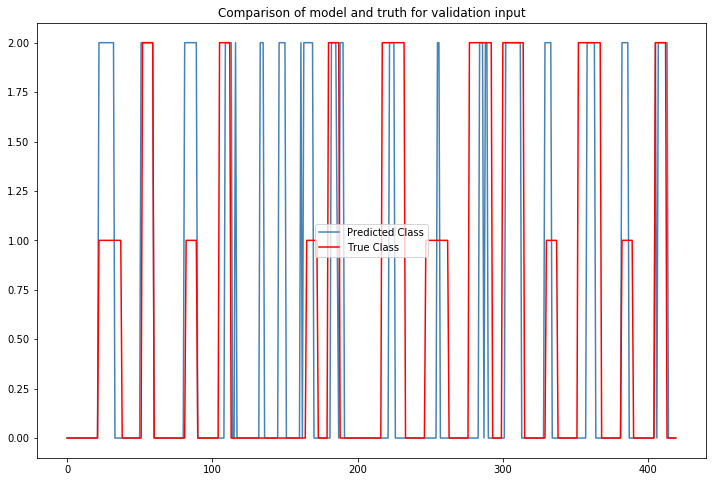

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(pred_final, color='steelblue')
ax.plot(label_final, color='red')
plt.title('Comparison of model and truth for validation input')
plt.legend(['Predicted Class','True Class'])
plt.show()

It's clear that the model is struggling to predict leaving vs entering. Overall, a good start, need more data

## Still a little bit of underfitting
- Areas for improvment
    - ~~More diverse dataset~~ (2020-04-01)
    - Hyperparameter tuning (some improvement 2020-04-04)
    - Make video window overlapping
    - ~~How to freeze some layers?~~ (2020-03-13)

In [35]:
weight_save_path=Path('/media/tris/tris_files/porta3.pth')
torch.save(my_model.state_dict(), weight_save_path)